In [208]:
import json
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import random

In [209]:
files = []
for file in os.listdir("./data/"):
    if file.endswith(".json"):
        files.append(file)

In [210]:
def get_raw_data():
    """
    Read .json files in ./data/ and append data to a dict with a key of sessions
    """
    data = {'sessions': []}
    for file in files:
        with open(f"./data/{file}", "r") as f:
            js = json.load(f)
            data['sessions'].extend(js['sessions'])
    
    return data

In [211]:
def what_commands(fname):
    """
    Return which commands were prompted in a given file (session)
    """
    with open (fname, "r") as f:
        js = json.load(f)
        commands = [entry['command'] for entry in js['sessions']]
    return commands

In [212]:
def organize_by_command(data):
    """
    Return a dict where key->command, value->list of list of keystrokes
    """
    commands = defaultdict(list)
    for session in data['sessions']:
        command = session['command']
        keystrokes = session['keystrokes']
        if len(keystrokes) == 0 or len(keystrokes) < len(command):
               continue
        commands[command].append(keystrokes)
    return commands

In [213]:
def zero_first(data):
    """
    Set latency of the first keystroke to zero.
    """
    for cmd in data.keys():
        for session in data[cmd]:
            session[0]['latency'] = 0
    return data

In [214]:
def get_prepared_data():
    """
    Return ordered, zeroed, data dictionary.
    """
    data = get_raw_data()
    organised = organize_by_command(data)
    zeroed = zero_first(organised)
    return zeroed

In [215]:
cmds = get_prepared_data()

In [202]:
[i for i in cmds if len(cmds[i]) >= 2]

['pwd',
 'sudo command',
 'cat file',
 'exit',
 'whoami',
 'systemctl status service',
 'umount /mnt',
 'uname -a',
 'free -m',
 'htop',
 'ss -tuln',
 'netstat -tuln',
 'wget https://example.com',
 'ifconfig',
 'ufw enable',
 'dnf install package',
 'dist-upgrade',
 'apt-get update',
 'sudo apt-get install package',
 'yum install package',
 'dd if=/dev/zero of=file bs=1M count=10',
 'pip3 install package',
 'tar -czvf archive.tar.gz directory',
 "awk '/pattern/ {action}' file",
 "sed 's/find/replace/' file",
 '--version',
 '-al',
 '-tlpn',
 '--file',
 '-v',
 'vim file',
 'mv * /tmp',
 'less file',
 'man command',
 'kill pid',
 'scp file root@host:path',
 'ip addr',
 'iptables -L',
 'dpkg -i package.deb',
 'sudo pacman -S package',
 'pacman -Syu',
 'unzip archive.zip',
 'sort file',
 '--help',
 'touch /etc/dhclient.conf',
 'su - user',
 'du -h directory',
 'uptime',
 'df -hT',
 'vmstat',
 'ping host',
 'sudo apt update',
 'python3 script.py',
 'tail -f /var/log/syslog',
 'chmod +x file'

In [216]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence in keystroke_sequences:
        latencies = [keystroke['latency'] for keystroke in sequence]
        plt.plot(latencies, marker='o', linestyle='-')

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend([f'Session {i+1}' for i in range(len(keystroke_sequences))], loc='upper right')
    plt.grid(True)
    plt.show()

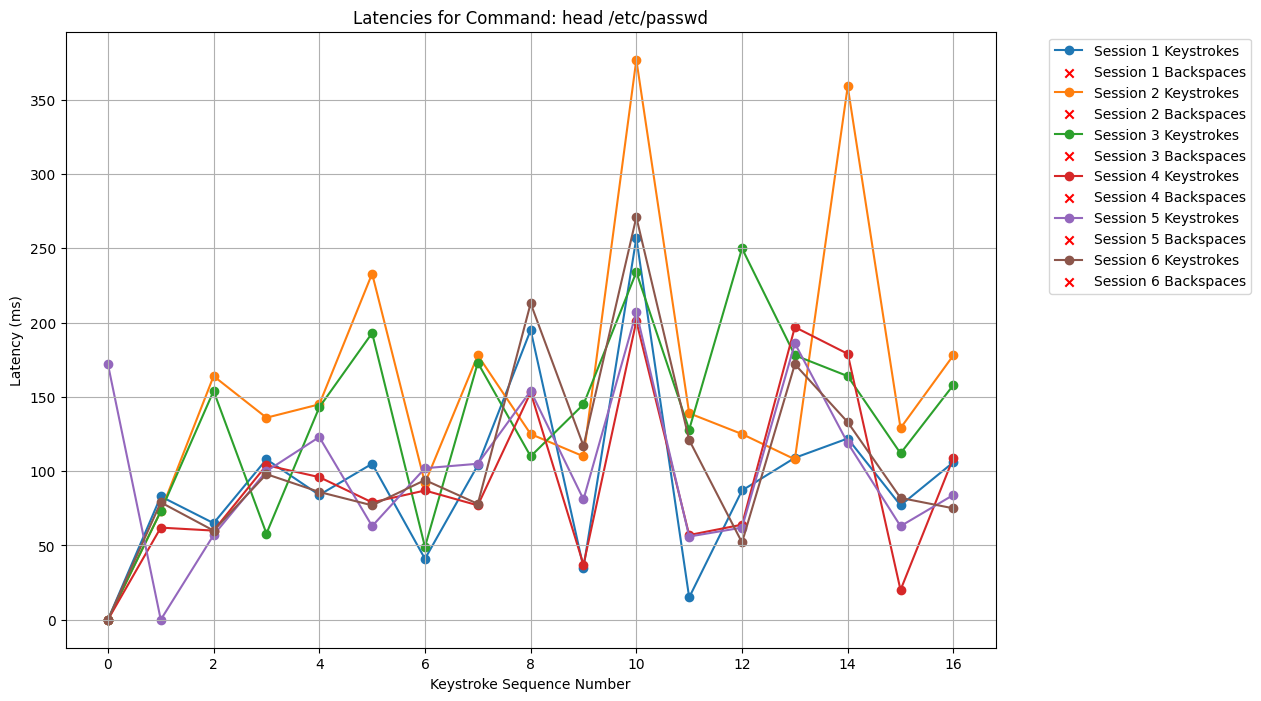

In [357]:
command = 'head /etc/passwd'
plot_command_latencies(cmds[command], command)

In [316]:
cmds['ifconfig'][2]

[{'key': 'i', 'latency': 0},
 {'key': 'd', 'latency': 250},
 {'key': 'Backspace', 'latency': 263},
 {'key': 'f', 'latency': 86},
 {'key': 'c', 'latency': 135},
 {'key': 'o', 'latency': 125},
 {'key': 'n', 'latency': 198},
 {'key': 'f', 'latency': 107},
 {'key': 'i', 'latency': 108},
 {'key': 'g', 'latency': 108},
 {'key': 'Return', 'latency': 108}]

In [337]:
def handle_backspaces(keystroke_sequences):
    for command in keystroke_sequences.keys():
        for sequence in keystroke_sequences[command]:
            i = 0
            while i < len(sequence)-1:
                if sequence[i]['key'] == 'Backspace':
                    curr = sequence[i]
                    prev = sequence[i-1]
                    if i != 0:
                        sequence.remove(prev)
                        sequence.remove(curr)
                        i -= 1
                        continue
                    else:
                        sequence.remove(curr)
                        sequence[i+1]['latency'] = 0
                        continue
                i += 1
    return keystroke_sequences

In [344]:
cmds = handle_backspaces(cmds)

In [345]:
def plot_command_latencies(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))
    
    for sequence_idx, sequence in enumerate(keystroke_sequences):
        normal_keys_x = []
        normal_keys_y = []
        backspace_keys_x = []
        backspace_keys_y = []
        
        for keystroke_idx, keystroke in enumerate(sequence):
            if keystroke['key'] == 'Backspace':
                backspace_keys_x.append(keystroke_idx)
                backspace_keys_y.append(keystroke['latency'])
            normal_keys_x.append(keystroke_idx)
            normal_keys_y.append(keystroke['latency'])
                
        # Plot normal keystrokes
        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session {sequence_idx + 1} Keystrokes', zorder=1)
        # Plot Backspace keystrokes
        plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session {sequence_idx + 1} Backspaces', zorder=2)

    plt.title(f'Latencies for Command: {command}')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

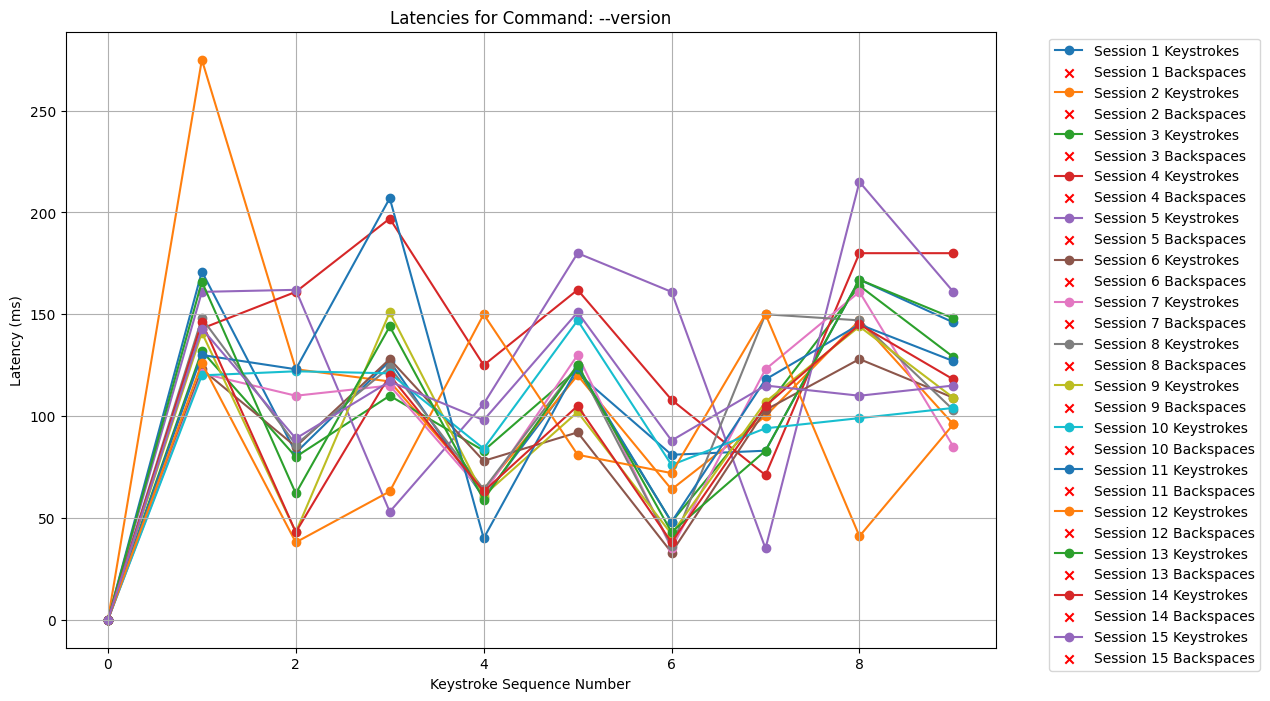

In [360]:
command = "--version"
plot_command_latencies(cmds[command], command)

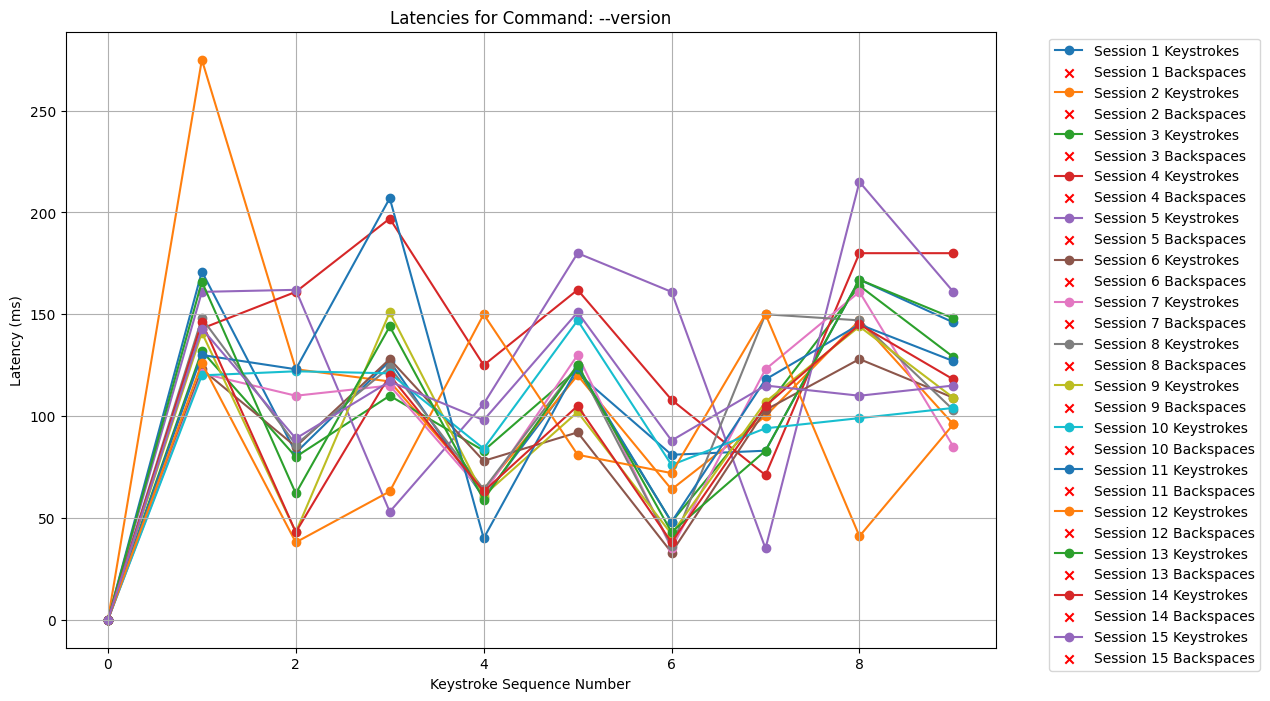

In [419]:
command = random.choice(list(cmds.keys()))
plot_command_latencies(cmds[command], command)

In [248]:
cmds['du -h directory'][3]

[{'key': 'd', 'latency': 0},
 {'key': 'u', 'latency': 68},
 {'key': ' ', 'latency': 107},
 {'key': '-', 'latency': 174},
 {'key': 'h', 'latency': 160},
 {'key': ' ', 'latency': 82},
 {'key': 'd', 'latency': 228},
 {'key': 'i', 'latency': 91},
 {'key': 'r', 'latency': 103},
 {'key': 'e', 'latency': 81},
 {'key': 'c', 'latency': 170},
 {'key': 'y', 'latency': 208},
 {'key': 't', 'latency': 22},
 {'key': 'o', 'latency': 72},
 {'key': 'Backspace', 'latency': 273},
 {'key': 'Backspace', 'latency': 125},
 {'key': 'Backspace', 'latency': 126},
 {'key': 'y', 'latency': 181},
 {'key': 'Backspace', 'latency': 417},
 {'key': 't', 'latency': 73},
 {'key': 'o', 'latency': 92},
 {'key': 'r', 'latency': 59},
 {'key': 'y', 'latency': 67},
 {'key': 'Return', 'latency': 213}]

In [282]:
import numpy as np
from scipy.interpolate import make_interp_spline

In [285]:
def plot_command_distribution(keystroke_sequences, command):
    plt.figure(figsize=(12, 8))

    total_latencies = [0] * (len(command) + 1)
    count_per_position = [0] * (len(command) + 1)

    # Plot each keystroke sequence
    for sequence in keystroke_sequences:
        normal_keys_x = []
        normal_keys_y = []
        
        for idx, keystroke in enumerate(sequence):
            normal_keys_x.append(idx)
            normal_keys_y.append(keystroke['latency'])
            if idx < len(total_latencies):
                total_latencies[idx] += keystroke['latency']
                count_per_position[idx] += 1

        plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', color='blue', alpha=0.3, zorder=1)
    
    # Calculate mean latencies
    means = [total_latencies[i] / count_per_position[i] if count_per_position[i] else 0 for i in range(len(command)+1)]
    x_new = np.linspace(0, len(command), 300)  # 300 represents number of points to make between T.min and T.max

    # Smoothing the line
    spl = make_interp_spline(range(len(command)+1), means, k=3)  # BSpline object
    y_smooth = spl(x_new)

    plt.plot(x_new, y_smooth, marker='', linestyle='-', label='Mean keystroke latency', color='red', linewidth=2, zorder=2)

    plt.title(f'Mean latencies for command: "{command}"')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()

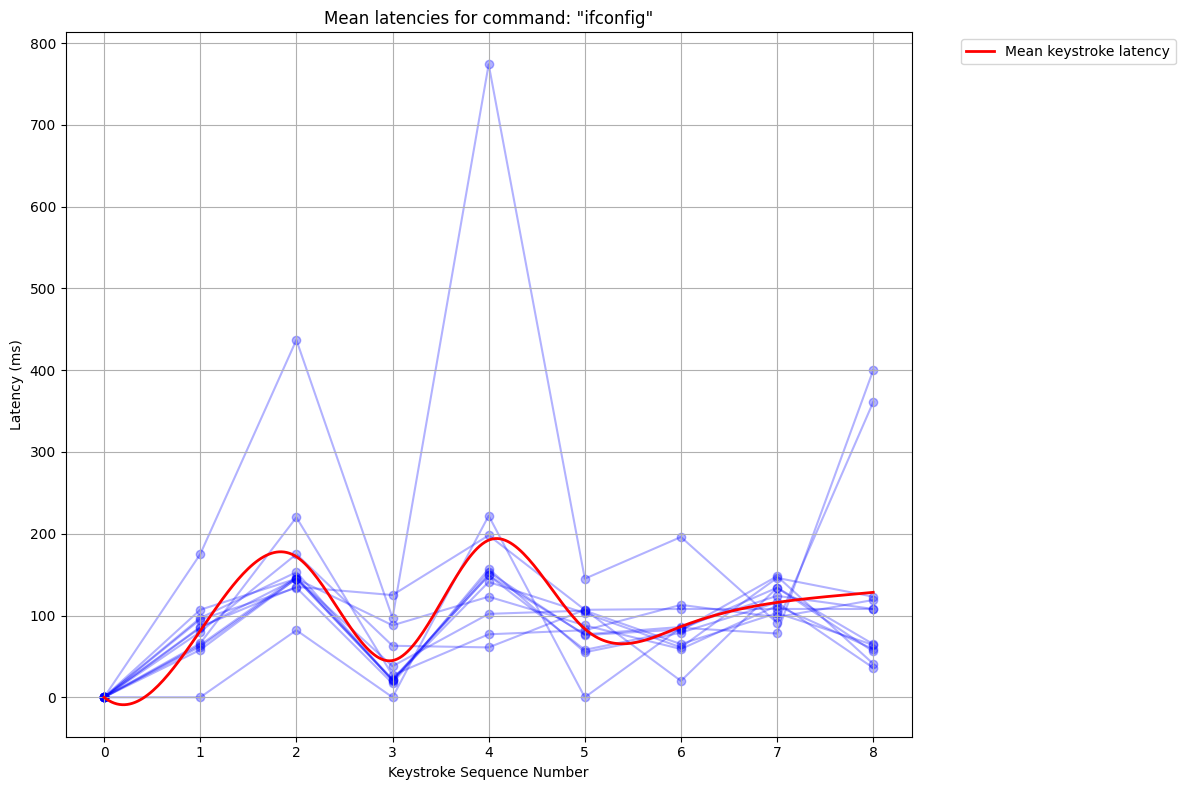

In [362]:
command = 'ifconfig'
plot_command_distribution(cmds[command], command)

In [34]:
def load_ssh_data(path):
    with open(path, "r") as f:
        data = json.loads(f.read())
    return data

In [20]:
ssh_data = load_ssh_data("/tmp/keystrokes.json")

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/keystrokes.json'

In [18]:
ssh_data[0]

NameError: name 'ssh_data' is not defined

In [275]:
def plot_ssh_data(sequence):
    plt.figure(figsize=(12, 8))
    normal_keys_x = []
    normal_keys_y = []
    backspace_keys_x = []
    backspace_keys_y = []
    enter_keys_x = []
    enter_keys_y = []

    for keystroke_idx, keystroke in enumerate(sequence):
        if keystroke['k_type'] == 'Delete':
            backspace_keys_x.append(keystroke_idx)
            backspace_keys_y.append(keystroke['timestamp'] / 1000)
        elif keystroke['k_type'] == 'Enter':
            enter_keys_x.append(keystroke_idx)
            enter_keys_y.append(keystroke['timestamp'] / 1000)
        normal_keys_x.append(keystroke_idx)
        normal_keys_y.append(keystroke['timestamp'] / 1000)
                
    # Plot normal keystrokes
    plt.plot(normal_keys_x, normal_keys_y, marker='o', linestyle='-', label=f'Session 1 Keystrokes', zorder=1)
    # Plot Backspace keystrokes
    plt.scatter(backspace_keys_x, backspace_keys_y, color='red', marker='x', label=f'Session 1 Backspaces', zorder=2)
    plt.scatter(enter_keys_x, enter_keys_y, color='green', marker='x', label=f'Session 1 Return', zorder=3)

    plt.title(f'Latencies for SSH sequence')
    plt.xlabel('Keystroke Sequence Number')
    plt.ylabel('Latency (ms)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

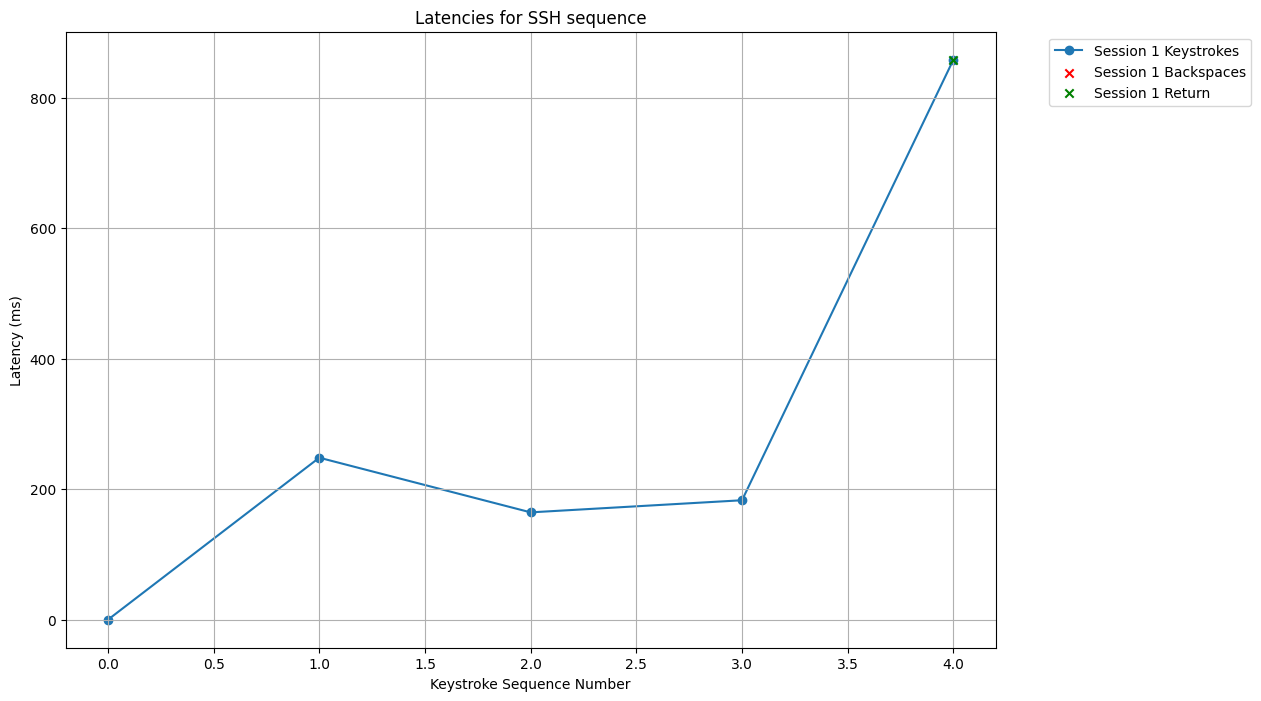

In [276]:
plot_ssh_data(ssh_data[2])

In [237]:
def plot_ssh_data(ssh_sessions):
    plt.figure(figsize=(12, 8))
    
    for session_idx, session in enumerate(ssh_sessions):
        keystroke_times = [event['timestamp'] / 1000 for event in session if event['k_type'] == 'Keystroke']  # Convert to milliseconds
        enter_times = [event['timestamp'] / 1000 for event in session if event['k_type'] == 'Enter']
        enter_sizes = [event['response_size'] for event in session if event['k_type'] == 'Enter']
        
        # Plotting keystrokes
        plt.plot(keystroke_times, [session_idx + 1] * len(keystroke_times), 'bo', label='Keystrokes' if session_idx == 0 else "")
        
        # Plotting Enter presses
        for enter_time, size in zip(enter_times, enter_sizes):
            plt.plot(enter_time, session_idx + 1, 'rx', label='Enter Press' if session_idx == 0 else "")
            plt.text(enter_time, session_idx + 1, f' {size}B', verticalalignment='bottom')

    plt.yticks(range(1, len(ssh_sessions) + 1), [f'Session {i+1}' for i in range(len(ssh_sessions))])
    plt.title('SSH Packet Timestamps and Enter Presses')
    plt.xlabel('Time (ms)')
    plt.ylabel('Session Number')
    plt.legend()
    plt.grid(True)
    plt.show()

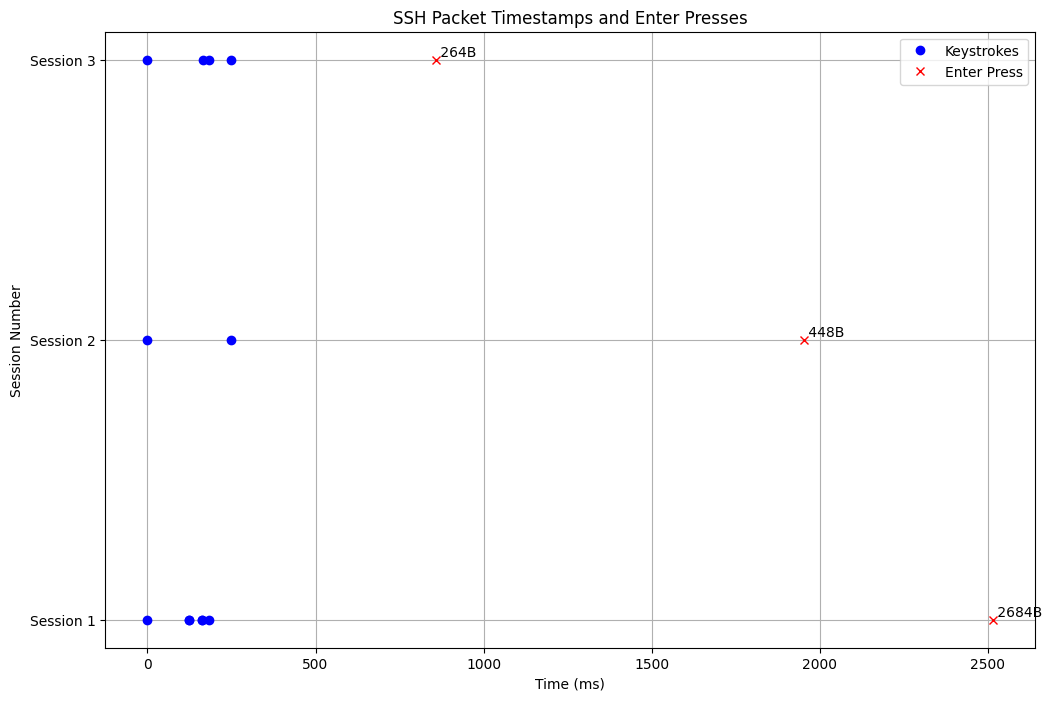

In [239]:
plot_ssh_data(ssh_data)

In [2]:
# HMM Stuff

In [45]:
with open("./commands.json", "r") as f:
    commands = json.load(f)

In [46]:
s_cmds = []
for category in commands['commands']:
    s_cmds.extend(category['patterns'])
s_cmds.extend(commands['commonFlags'])
s_cmds.extend(commands['commonPathStarts'])

In [47]:
s_cmds

['ls -l',
 'cd',
 'pwd',
 'touch ',
 'cp file1 file2',
 'mv file1 file2',
 'rm file',
 'mkdir directory',
 'rmdir directory',
 'cat file',
 'less file',
 'nano file',
 'vim file',
 'chmod +x file',
 'chown user:group file',
 'sudo command',
 'su - user',
 'whoami',
 'man command',
 "echo 'text'",
 'head ',
 'tail -f ',
 'exit',
 'ps -aux',
 'top',
 'htop',
 'kill pid',
 'df -h',
 'du -h directory',
 'uname -a',
 'uptime',
 'free -m',
 'vmstat',
 'iostat',
 'systemctl status service',
 'service name start',
 'ping host',
 'netstat -tuln',
 'ss -tuln',
 'curl https://example.com',
 'wget https://example.com',
 'scp file user@host:path',
 'ssh user@host',
 'iptables -L',
 'ufw enable',
 'ip addr',
 'apt-get update',
 'apt-get install package',
 'dpkg -i package.deb',
 'yum install package',
 'dnf install package',
 'pacman -Syu',
 'pacman -S package',
 "grep -i 'pattern' file",
 "awk '/pattern/ {action}' file",
 "sed 's/find/replace/' file",
 'sort file',
 'uniq file',
 'tar -czvf archive

In [48]:
char_pairs = set()

for cmd in s_cmds:
    for i in range(len(cmd) - 1):
        pair = cmd[i:i+2]
        char_pairs.add(pair)

In [49]:
char_pairs

{" '",
 ' +',
 ' -',
 ' a',
 ' b',
 ' c',
 ' d',
 ' e',
 ' f',
 ' h',
 ' i',
 ' n',
 ' o',
 ' p',
 ' s',
 ' u',
 ' {',
 "' ",
 "'/",
 "'p",
 "'s",
 "'t",
 '+x',
 '- ',
 '--',
 '-L',
 '-S',
 '-a',
 '-c',
 '-f',
 '-g',
 '-h',
 '-i',
 '-l',
 '-m',
 '-t',
 '-v',
 '..',
 './',
 '.c',
 '.d',
 '.g',
 '.p',
 '.t',
 '.z',
 '/ ',
 "/'",
 '//',
 '/d',
 '/e',
 '/f',
 '/p',
 '/r',
 '/z',
 '1 ',
 '10',
 '1M',
 '3 ',
 ':/',
 ':g',
 ':p',
 '=/',
 '=1',
 '=f',
 '@h',
 'M ',
 'S ',
 'Sy',
 'ab',
 'ac',
 'ad',
 'ag',
 'ai',
 'al',
 'am',
 'an',
 'ap',
 'ar',
 'at',
 'au',
 'aw',
 'bl',
 'bs',
 'ca',
 'cd',
 'ce',
 'ch',
 'ck',
 'cm',
 'co',
 'cp',
 'cr',
 'ct',
 'cu',
 'cz',
 'd ',
 'd/',
 'da',
 'dd',
 'de',
 'df',
 'di',
 'dn',
 'do',
 'dp',
 'dr',
 'du',
 'e ',
 'e.',
 'e/',
 'e1',
 'e2',
 'ea',
 'eb',
 'ec',
 'ed',
 'ee',
 'el',
 'em',
 'en',
 'ep',
 'er',
 'es',
 'et',
 'ev',
 'ex',
 'f ',
 'f=',
 'fi',
 'fr',
 'fw',
 'g ',
 'ge',
 'gr',
 'gz',
 'h ',
 'he',
 'hi',
 'hm',
 'ho',
 'ht',
 'i ',
 'ic',

In [50]:
len(char_pairs)

296

In [138]:
def get_minlen(command: str) -> int:
    # How do we reliably determine minimum length?
    # Split at first ' ' doesn't cover cmds like 'cp src dst' but it is a start.
    splice = command.split(" ", 1)[0]
    return len(splice)

In [139]:
def get_charpairs(command: str) -> (str, set()):
    if len(command) < 2:
        return
    first = set([command[:2]])
    rest = set()
    for i in range(1, len(command)-1):
        rest.add(command[i:i+2])
    return [first, rest]

In [147]:
# This one doesn't make much sense. Each start state can only logically produce certain following states, so it doesn't make sense to pool them by length
def make_state_objects(commands: list):
    # minlen -> (startstates, states)?
    state_objects = {}
    # (minlen, startstate, states)
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_charpairs(command)
        if not pairs:
            continue
        if minlen in state_objects:
            state_objects[minlen][0] = state_objects[minlen][0].union(pairs[0])
            state_objects[minlen][1] = state_objects[minlen][1].union(pairs[1])
        else:
            state_objects[minlen] = pairs
    return state_objects

In [175]:
def get_pairs(command: str):
    pairs = []
    for i in range(len(command) - 1):
        pair = command[i:i+2]
        pairs.append(pair)
    return pairs

In [188]:
def make_len_map(commands: list):
    # minlen -> [["if", "fc", "co", "on", "nf", "fi", "ig"], ...]
    lenmap = {}
    for command in commands:
        minlen = get_minlen(command)
        pairs = get_pairs(command)
        if not pairs:
            continue
        if minlen in lenmap:
            lenmap[minlen].append(pairs)
        else:
            lenmap[minlen] = [pairs]
    return lenmap

In [189]:
mp = make_len_map(s_cmds)

In [193]:
mp[5]

[['to', 'ou', 'uc', 'ch', 'h '],
 ['mk',
  'kd',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['rm',
  'md',
  'di',
  'ir',
  'r ',
  ' d',
  'di',
  'ir',
  're',
  'ec',
  'ct',
  'to',
  'or',
  'ry'],
 ['ch', 'hm', 'mo', 'od', 'd ', ' +', '+x', 'x ', ' f', 'fi', 'il', 'le'],
 ['ch',
  'ho',
  'ow',
  'wn',
  'n ',
  ' u',
  'us',
  'se',
  'er',
  'r:',
  ':g',
  'gr',
  'ro',
  'ou',
  'up',
  'p ',
  ' f',
  'fi',
  'il',
  'le'],
 ['un', 'na', 'am', 'me', 'e ', ' -', '-a'],
 ['un',
  'nz',
  'zi',
  'ip',
  'p ',
  ' a',
  'ar',
  'rc',
  'ch',
  'hi',
  'iv',
  've',
  'e.',
  '.z',
  'zi',
  'ip']]